In [1]:
# Import packages
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

# Display plots inline
# matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import sparse, stats

Using TensorFlow backend.


In [2]:
# Download nltk - only need to run once
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Get encoding of data file
with open("author_data.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [4]:
# Load data (uncomment relevant line)
# Local version
#data = pd.read_csv("author_data.csv", encoding="utf-8")

# Floydhub version
data = pd.read_csv("author_data.csv", encoding="utf-8")
print(data.head())

                                                text      author
0  Some of the "New Women" writers will some day ...      Stoker
1   I mean the fact that you told a falsehood today.  Montgomery
2                                says the bald-head.       Twain
3  "I shall marry whom I please, Aunt March, and ...      Alcott
4   “Perhaps it was nothing very dreadful after all.  Montgomery


In [5]:
# Create feature (text) and label (author) lists
text = list(data['text'].values)
author = list(data['author'].values)

print("The author dataset contains {} datapoints.".format(len(text)))

The author dataset contains 40000 datapoints.


In [6]:
# Check distribution of authors in the data
Counter(author)

Counter({'Stoker': 4000,
         'Montgomery': 4000,
         'Twain': 4000,
         'Alcott': 4000,
         'Swift': 4000,
         'Thatcher': 4000,
         'Doyle': 4000,
         'Sinclair': 4000,
         'Austen': 4000,
         'Dickens': 4000})

In [7]:
print(text[2000])

“That is unusual in a young girl”.


In [8]:
print(text[4000])

And, Anne, as she talked about it the thought came to me that I would ask her to come and live with me, but I thought I ought to talk it over with you first before I said anything to her.


In [9]:
print(text[6000])

How you talk, you better say; you don't know nothing about it.


In [10]:
print(text[8000])

The crack was wide while Dede Antanas was hunting a job—and it was yet wider when he finally got it.


In [11]:
print(text[10000])

We all moved out to the hall with one impulse, and Van Helsing, holding up his hand to us to keep silence, stepped to the door and opened it.


In [12]:
print(text[20000])

“Oh, Miss Shirley,” he cried excitedly, “you can’t think what has happened!


In [13]:
print(text[30000])

Jo rather prided herself upon her shopping capabilities, and particularly wished to impress her escort with the neatness and dispatch with which she would accomplish the business.


In [14]:
print(text[39000])

My horses understand me tolerably well; I converse with them at least four hours every day.


In [15]:
print(text[39999])

She supposed she must say more before she were entitled to his clemency; but it was a hard case to be obliged still to lower herself in his opinion.


In [16]:
# Create word count and character count lists
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)

In [17]:
def get_stats(var):
    
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [18]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 1
Max: 277
Mean: 20.8026
Median 16.0
1st percentile 1.0
95th percentile 53.0
99th percentile 85.0
99.5th Percentile 99.00499999999738
99.9th Percentile 138.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

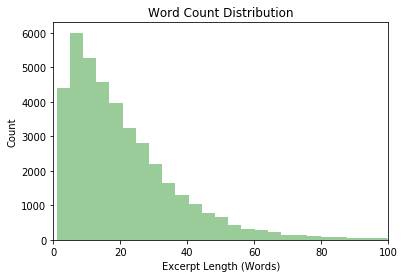

In [19]:
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'green').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 100)
plt.savefig("word_count.eps")


In [20]:
print("\nCharacter count statistics")
get_stats(char_count)


Character count statistics
Min: 5
Max: 1570
Mean: 111.22065
Median 86.0
1st percentile 7.0
95th percentile 293.0
99th percentile 467.0
99.5th Percentile 545.0
99.9th Percentile 781.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

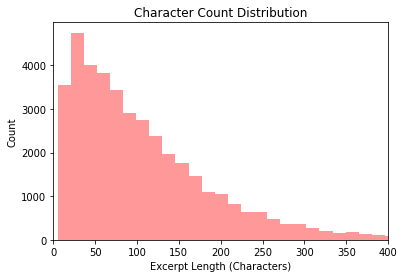

In [21]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'red').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 400)
plt.savefig("char_count.eps")

In [22]:
print("\nAverage length statistics")
get_stats(ave_length)


Average length statistics
Min: 3.0
Max: 18.0
Mean: 5.362977606250826
Median 5.285714285714286
1st percentile 3.909047619047619
95th percentile 6.615384615384615
99th percentile 8.0
99.5th Percentile 9.0
99.9th Percentile 12.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

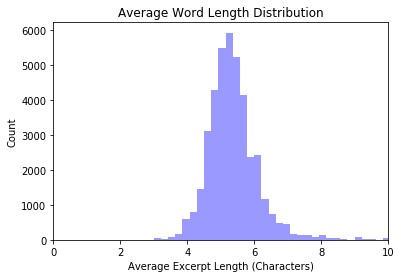

In [23]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 10)
plt.savefig("ave_length.eps")

In [24]:
# Get word count outliers
word_outliers = np.where(word_count > 150)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 497 - Length: 159
As I was saying—”  Her look so discomposed him that he stopped, wandered, and began anew:  “As I was saying; if Monsieur Manette had not died; if he had suddenly and silently disappeared; if he had been spirited away; if it had not been difficult to guess to what dreadful place, though no art could trace him; if he had an enemy in some compatriot who could exercise a privilege that I in my own time have known the boldest people afraid to speak of in a whisper, across the water there; for instance, the privilege of filling up blank forms for the consignment of any one to the oblivion of a prison for any length of time; if his wife had implored the king, the queen, the court, the clergy, for any tidings of him, and all quite in vain;—then the history of your father would have been the history of this unfortunate gentleman, the Doctor of Beauvais”. 

Excerpt 520 - Length: 266
The first thing to see, looking away over the water, was a kind of dull line that was th

In [25]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 55 - Length: 1
“Well! 

Excerpt 93 - Length: 1
“Can't-be. 

Excerpt 127 - Length: 1
Vynas. 

Excerpt 159 - Length: 1
“Extermination”. 

Excerpt 336 - Length: 1
Business! 

Excerpt 341 - Length: 1
“See”! 

Excerpt 352 - Length: 1
“Noth'n”. 

Excerpt 411 - Length: 1
(Amen!) 

Excerpt 421 - Length: 1
“Yes. 

Excerpt 448 - Length: 1
XXII. 

Excerpt 460 - Length: 1
“Yes. 

Excerpt 574 - Length: 1
“Mrs. 

Excerpt 621 - Length: 1
Yaha! 

Excerpt 887 - Length: 1
“No”. 

Excerpt 1043 - Length: 1
Lucie! 

Excerpt 1065 - Length: 1
“Mrs. 

Excerpt 1169 - Length: 1
“Hah! 

Excerpt 1180 - Length: 1
"Come!" 

Excerpt 1298 - Length: 1
“Well! 

Excerpt 1322 - Length: 1
"Well?" 

Excerpt 1336 - Length: 1
‘Mrs. 

Excerpt 1357 - Length: 1
‘Tired? 

Excerpt 1448 - Length: 1
“Certainly”. 

Excerpt 1472 - Length: 1
look!" 

Excerpt 1495 - Length: 1
Graminivorous. 

Excerpt 1529 - Length: 1
Advocate. 

Excerpt 1567 - Length: 1
“‘St. 

Excerpt 1597 - Length: 1
Why”? 

Excerpt 1613 - Length: 1
Spi—ies”!

In [26]:
# Get average length outliers
length_outliers = np.where(ave_length > 10)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 159 - Average Length: 16.0
“Extermination”. 

Excerpt 1448 - Average Length: 12.0
“Certainly”. 

Excerpt 1495 - Average Length: 14.0
Graminivorous. 

Excerpt 1686 - Average Length: 12.0
“Yesterday”. 

Excerpt 1980 - Average Length: 10.5
‘National Prosperity. 

Excerpt 4452 - Average Length: 12.0
“Knightley”! 

Excerpt 4589 - Average Length: 10.666666666666666
“Very interesting remembrances”! 

Excerpt 4956 - Average Length: 11.0
"Certainly. 

Excerpt 5743 - Average Length: 11.0
Everything? 

Excerpt 5800 - Average Length: 11.0
Everything? 

Excerpt 6307 - Average Length: 12.0
so-ho-then”! 

Excerpt 6538 - Average Length: 13.0
“Undoubtedly. 

Excerpt 6569 - Average Length: 12.0
“Yesterday”. 

Excerpt 6733 - Average Length: 11.0
“Only four-and-twenty. 

Excerpt 7701 - Average Length: 12.0
Impossible”! 

Excerpt 8282 - Average Length: 11.0
“Straight”! 

Excerpt 9434 - Average Length: 11.0
“Excellent! 

Excerpt 9488 - Average Length: 12.0
“Difference! 

Excerpt 9563 - Average Lengt

In [27]:
length_outliers = np.where(ave_length < 3.5)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 698 - Average Length: 3.4
“To be sure I am. 

Excerpt 1066 - Average Length: 3.0
“Yes . 

Excerpt 1476 - Average Length: 3.0
Go on! 

Excerpt 1819 - Average Length: 3.2
As wet as a sop. 

Excerpt 1869 - Average Length: 3.3333333333333335
oh my God! 

Excerpt 4018 - Average Length: 3.0
I did. 

Excerpt 4621 - Average Length: 3.0
‘I do. 

Excerpt 5314 - Average Length: 3.2
What am I to do? 

Excerpt 5515 - Average Length: 3.0
Ah me! 

Excerpt 6107 - Average Length: 3.0
‘I do. 

Excerpt 8298 - Average Length: 3.0
Is a cow a man? 

Excerpt 8318 - Average Length: 3.1666666666666665
er is a cow a cat”? 

Excerpt 8344 - Average Length: 3.3333333333333335
Let us go. 

Excerpt 9608 - Average Length: 3.0
“O me, O me! 

Excerpt 9889 - Average Length: 3.0
I am old. 

Excerpt 9974 - Average Length: 3.0
It is. 

Excerpt 10073 - Average Length: 3.25
So I done it. 

Excerpt 10336 - Average Length: 3.375
But I'll do it ef I got to. 

Excerpt 11416 - Average Length: 3.25
“And so do I. 

Excerpt 

In [28]:
# Create string containing all excerpts in lower case
text_string = ''

for i in range(len(text)):
    text_string += text[i].lower()

# Get character frequencies
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))

Counter({' ': 798362, 'e': 428449, 't': 316021, 'a': 284010, 'o': 270492, 'n': 240663, 'i': 232924, 'h': 224052, 's': 214760, 'r': 199351, 'd': 160714, 'l': 138247, 'u': 101598, 'm': 93321, 'w': 88127, 'c': 77935, 'f': 75316, 'y': 73845, 'g': 71827, ',': 68407, 'p': 56480, 'b': 53664, '.': 38678, 'v': 32868, 'k': 29496, "'": 8660, '“': 8100, ';': 7816, '”': 7705, '’': 7463, 'j': 6208, 'x': 4645, '-': 4131, '"': 3999, '?': 3543, '!': 3270, 'q': 3250, '‘': 2475, '—': 2103, 'z': 1612, ':': 1502, ')': 468, '(': 458, '*': 363, '1': 315, '0': 169, '2': 164, '7': 105, '6': 102, '4': 98, '3': 94, '8': 81, '5': 80, '9': 73, ']': 28, '[': 27, '£': 23, 'æ': 18, '&': 16, '\xa0': 16, '#': 6, 'é': 6, 'è': 6, 'ë': 4, 'à': 3, 'ö': 3, '–': 2, '\ufeff': 2, 'ô': 2, 'â': 2, 'ï': 1, 'œ': 1, '\t': 1})
73


In [29]:
# Get character count dictionary keys
print(list(char_cnt.keys()))

['s', 'o', 'm', 'e', ' ', 'f', 't', 'h', '"', 'n', 'w', 'r', 'i', 'l', 'd', 'a', 'y', 'u', 'b', 'c', 'p', 'g', '.', '-', ',', 'v', 'k', '“', '‘', "'", '’', 'q', ';', ':', '”', 'z', '?', 'j', 'x', '(', ')', '!', '—', '*', '5', '4', '1', '7', '2', '0', '6', '8', '9', '&', '3', '–', '£', '[', '#', ']', 'é', 'è', 'à', 'æ', 'ë', 'ö', '\xa0', '\ufeff', 'ô', 'ï', 'œ', 'â', '\t']


In [30]:
# Create list of accented characters
accented_chars = ['ï', 'é', 'ñ', 'è', 'ö', 'æ', 'ô', 'â', 'á', 'à', 'ê', 'ë']

# Find all texts containing unusual characters
accented_text = []

for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)
        
accented_text = list(set(accented_text))
 
print('There are', str(len(accented_text)), 'texts containing accented characters.')

There are 42 texts containing accented characters.


In [31]:
# Print accented texts
for i in accented_text:
    print("Excerpt {}".format(i))
    print(text[i] + '\n')

Excerpt 10753
It seemed altogether past belief that anyone could make such a will, or that they would pay such a sum for doing anything so simple as copying out the Encyclopædia Britannica.

Excerpt 6147
After much debate, they concluded unanimously, that I was only relplum scalcath, which is interpreted literally lusus naturæ; a determination exactly agreeable to the modern philosophy of Europe, whose professors, disdaining the old evasion of occult causes, whereby the followers of Aristotle endeavoured in vain to disguise their ignorance, have invented this wonderful solution of all difficulties, to the unspeakable advancement of human knowledge.

Excerpt 27910
I observed, with much pleasure, that these two persons were in good intelligence with each other; and Cæsar freely confessed to me, “that the greatest actions of his own life were not equal, by many degrees, to the glory of taking it away”.

Excerpt 34828
This was all done en règle; and in our work we shall be en règle too.

E

In [32]:
# Remove invalid character from text
text = [excerpt.replace('\xa0', '') for excerpt in text]

In [33]:
# Verify character has been removed
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == '\xa0':
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('There are', str(len(unusual_text)), 'texts containing the invalid character.')

There are 0 texts containing the invalid character.


In [34]:
# Count texts containing white space blocks
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 2606 excerpts containing blocks of white space.


In [35]:
# Remove blocks of white space
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
print(len(text))

40000


In [36]:
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 0 excerpts containing blocks of white space.


In [37]:
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)
    
print(normed_text[0:5])    
print(len(normed_text))

['some of the new women writers will some day start an idea that men and women should be allowed to see each other asleep before proposing or accepting', 'i mean the fact that you told a falsehood today', 'says the baldhead', 'i shall marry whom i please aunt march and you can leave your money to anyone you like she said nodding her head with a resolute air', 'perhaps it was nothing very dreadful after all']
40000


In [38]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size = 0.2, random_state = 5)

In [39]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(32000,)
(8000,)
(32000,)
(8000,)


In [40]:
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences
    
    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [41]:
def get_vocab_size(excerpt_list, n, seq_size):
    
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

In [42]:
# Determine vocab sizes

for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 52
Vocab size for n = 2 is: 1054
Vocab size for n = 3 is: 10246


In [43]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 51, 350)
gram2_train = create_n_grams(text_train, 2, 966, 350)
gram3_train = create_n_grams(text_train, 3, 9521, 350)

gram1_test = create_n_grams(text_test, 1, 51, 350)
gram2_test = create_n_grams(text_test, 2, 966, 350)
gram3_test = create_n_grams(text_test, 3, 9521, 350)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(32000, 350)
(32000, 350)
(32000, 350)
(8000, 350)
(8000, 350)
(8000, 350)


In [44]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  64
Maximum encoding value for 2-grams is:  1254
Maximum encoding value for 3-grams is:  12376


In [45]:
def process_data(excerpt_list):
    
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [46]:
# Process data subsets
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['tire death nois big citi crowd peopl alway come go care noth', 'said van hels agonis voic', 'held snuffbox old gold great amethyst centr lid', 'consol restor brought remembr aris pass us moon last night—what say', 'quit forget poor mr weston']


In [47]:
# Create bag of words features
## Fit Tfidf Vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Get size of vocabulary
print('Vocabulary size: ', len(vectorizer.vocabulary_))

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Vocabulary size:  4976


In [48]:
# One hot encode labels
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [49]:
# Define model architecture in keras
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [50]:
# Create the 1-gram model
gram1_model = define_model(350, 10, max_1gram + 1, 26)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 26)      1690        input_1[0][0]                    
____________________________________________________________________________________________

In [51]:
# Train 1-gram CNN
gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=3, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/3
25600/25600 [==============================] - 651s 25ms/step - loss: 2.2364 - accuracy: 0.1617 - val_loss: 2.1993 - val_accuracy: 0.1923
Epoch 2/3
25600/25600 [==============================] - 706s 28ms/step - loss: 2.0790 - accuracy: 0.2513 - val_loss: 2.0268 - val_accuracy: 0.2650
Epoch 3/3
25600/25600 [==============================] - 647s 25ms/step - loss: 1.9156 - accuracy: 0.3183 - val_loss: 1.9383 - val_accuracy: 0.3031


In [52]:
# Create the 2-gram model
gram2_model = define_model(350, 10, max_2gram + 1, 300)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 350, 300)     376500      input_4[0][0]                    
____________________________________________________________________________________________

In [53]:
# Train 2-gram CNN
gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=3, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/3
25600/25600 [==============================] - 2231s 87ms/step - loss: 2.2115 - accuracy: 0.1848 - val_loss: 2.0907 - val_accuracy: 0.2572
Epoch 2/3
25600/25600 [==============================] - 2352s 92ms/step - loss: 1.8145 - accuracy: 0.3738 - val_loss: 1.7047 - val_accuracy: 0.4139
Epoch 3/3
25600/25600 [==============================] - 2682s 105ms/step - loss: 1.4436 - accuracy: 0.5200 - val_loss: 1.5817 - val_accuracy: 0.4602


In [54]:
# Create the 3-gram model
gram3_model = define_model(350, 10, max_3gram + 1, 600)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 350, 600)     7426200     input_7[0][0]                    
____________________________________________________________________________________________

In [55]:
# Train 3-gram CNN
gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=3, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/3
25600/25600 [==============================] - 3881s 152ms/step - loss: 2.1951 - accuracy: 0.1952 - val_loss: 2.0071 - val_accuracy: 0.3016
Epoch 2/3
25600/25600 [==============================] - 3849s 150ms/step - loss: 1.5413 - accuracy: 0.4925 - val_loss: 1.3646 - val_accuracy: 0.5356
Epoch 3/3
25600/25600 [==============================] - 3860s 151ms/step - loss: 0.9750 - accuracy: 0.6938 - val_loss: 1.1503 - val_accuracy: 0.6137


In [56]:
# Define grid search object
svm = SVC()
params = {'kernel': ['linear'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [57]:
# Fit bag of words svm
np.random.seed(6)
word_svm = grid_obj.fit(words_train, author_train)

C:\Users\sheik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.647, total= 1.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.647, total= 1.1min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.650, total= 1.1min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min remaining:    0.0s
[CV] C=10, kernel=linear .............................................
[CV] ................. C=10, kernel=linear, score=0.648, total= 1.1min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:

In [58]:
print(word_svm.best_estimator_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [59]:
print(word_svm.cv_results_)

{'mean_fit_time': array([48.14121302, 47.34093157, 64.44088642]), 'std_fit_time': array([2.79090412, 0.33703761, 1.60465321]), 'mean_score_time': array([18.43516676, 16.90564243, 16.84934052]), 'std_score_time': array([0.21534552, 0.14753819, 0.25586499]), 'param_C': masked_array(data=[1, 10, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}], 'split0_test_score': array([0.64676664, 0.647985  , 0.63533271]), 'split1_test_score': array([0.64697609, 0.64725738, 0.63112986]), 'split2_test_score': array([0.65025785, 0.64903891, 0.63328645]), 'mean_test_score': array([0.648     , 0.64809375, 0.63325   ]), 'std_test_score': array([0.00159864, 0.0007313 , 0.00171606]), 'rank_test_score': arr

In [60]:
# Define model architecture in keras
def define_model2(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Channel 4
    inputs4 = Input(shape = (input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters = conv_filters, kernel_size = 6, activation = activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size = pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [61]:
# Create the 3-gram model
gram3_model2 = define_model2(350, 10, max_3gram + 1, 600)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 350)          0                                            
____________________________________________________________________________________________

In [62]:
# Train 3-gram CNN
gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=3, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/3
25600/25600 [==============================] - 5819s 227ms/step - loss: 2.1709 - accuracy: 0.2134 - val_loss: 1.9010 - val_accuracy: 0.3681
Epoch 2/3
25600/25600 [==============================] - 5632s 220ms/step - loss: 1.4343 - accuracy: 0.5304 - val_loss: 1.3109 - val_accuracy: 0.5539
Epoch 3/3
25600/25600 [==============================] - 5647s 221ms/step - loss: 0.8811 - accuracy: 0.7284 - val_loss: 1.1082 - val_accuracy: 0.6280


In [63]:
# Define function for plotting normalized confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

In [64]:
# Fit and evaluate Model 1 (3-gram CNN)

t0 = time.time()

# Fit model
model1 = define_model(350, 10, max_3gram + 1, 600)
model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=3, batch_size=32, 
           verbose = 1, validation_split = 0.2)
t1 = time.time()

# Predict values for test set
author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

# Reverse one-hot encoding of labels
author_pred1 = author_lb.inverse_transform(author_pred1)

# Evaluate
accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels = ['Dickens', 'Montgomery', 'Stoker', 'Austen', 
                                                                  'Swift', 'Thatcher', 'Twain', 'Alcott', 'Doyle', 'Sinclair'])
    
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 350, 600)     7426200     input_14[0][0]                   
____________________________________________________________________________________________

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/3
25600/25600 [==============================] - 4015s 157ms/step - loss: 2.1983 - accuracy: 0.1911 - val_loss: 2.0103 - val_accuracy: 0.3295
Epoch 2/3
25600/25600 [==============================] - 3737s 146ms/step - loss: 1.5418 - accuracy: 0.4908 - val_loss: 1.4003 - val_accuracy: 0.5192
Epoch 3/3
25600/25600 [==============================] - 3809s 149ms/step - loss: 0.9820 - accuracy: 0.6906 - val_loss: 1.1679 - val_accuracy: 0.6116
Accuracy: 0.620875
Ave. Precision: 0.6251767637630771
Ave. Recall: 0.6208750000000001
Ave. F1 Score: 0.618051980214127
Training Time: 11655.494950294495 seconds
Prediction Time: 336.2603712081909 seconds
Confusion Matrix:
 [[318  19  43  74  12  77  52  29 114  55]
 [  8 576  21  37   3  44  26  18  33  15]
 [ 44  11 402  80  18  26  45  28  97  62]
 [ 27  27  34 534  11  26  15  18  69  16]
 [ 10   6  16  33 706  17  10   0  31  12]
 [ 22  35  11  36   9 552  16  13  64  29]
 [ 24  12  19  22   

Normalized confusion matrix
[[0.40100883 0.02395965 0.05422446 0.09331652 0.01513241 0.09709962
  0.06557377 0.03656999 0.14375788 0.06935687]
 [0.01024328 0.73751601 0.0268886  0.04737516 0.00384123 0.05633803
  0.03329065 0.02304738 0.04225352 0.01920615]
 [0.05412054 0.01353014 0.49446494 0.09840098 0.02214022 0.03198032
  0.05535055 0.03444034 0.11931119 0.07626076]
 [0.03474903 0.03474903 0.04375804 0.68725869 0.01415701 0.03346203
  0.01930502 0.02316602 0.08880309 0.02059202]
 [0.01189061 0.00713436 0.01902497 0.039239   0.83947681 0.02021403
  0.01189061 0.         0.03686088 0.01426873]
 [0.02795426 0.04447268 0.01397713 0.04574333 0.01143583 0.70139771
  0.02033037 0.01651842 0.08132147 0.03684879]
 [0.03003755 0.01501877 0.02377972 0.02753442 0.00375469 0.01001252
  0.76720901 0.04380476 0.0387985  0.04005006]
 [0.05535055 0.06519065 0.06273063 0.11439114 0.0098401  0.05412054
  0.08610086 0.46617466 0.04797048 0.03813038]
 [0.07936508 0.03663004 0.07936508 0.08547009 0.0280

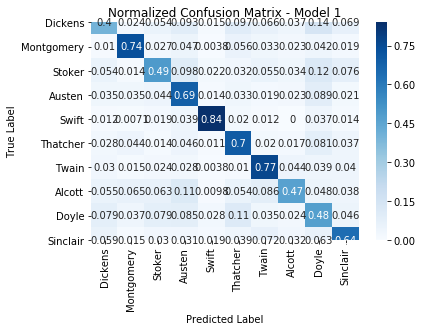

In [65]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['Dickens', 'Montgomery', 'Stoker', 'Austen', 
                                          'Swift', 'Thatcher', 'Twain', 'Alcott', 'Doyle', 'Sinclair'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 1')

plt.savefig("confusion1.eps")

In [66]:
# Fit and evaluate Model 2 (Bag of words SVM)
np.random.seed(28)

t0 = time.time()

# Fit model
model2 = SVC(C = 1, kernel = 'linear')
model2.fit(words_train, author_train)

t1 = time.time()

# Predict values for test set
author_pred2 = model2.predict(words_test)

t2 = time.time()

# Evaluate
accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support = score(author_test, author_pred2)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels =  ['Dickens', 'Montgomery', 'Stoker', 'Austen', 'Swift',
                                                                   'Thatcher', 'Twain', 'Alcott', 'Doyle', 'Sinclair'])

print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Accuracy: 0.659
Ave. Precision: 0.6728712551197962
Ave. Recall: 0.659
Ave. F1 Score: 0.662976593022266
Training Time: 101.700031042099 seconds
Prediction Time: 19.519829273223877 seconds
Confusion Matrix:
 [[430  10  64  55  17  27  18  21 114  37]
 [ 22 539  20  30   3  12  39  54  44  18]
 [ 52  15 464  47  14  15  26  48 102  30]
 [ 44   6  26 534  11  20  13  30  74  19]
 [ 23   3  22  22 705   7   7   6  32  14]
 [ 54  17  26  42  13 484  26  27  69  29]
 [ 27  17  25  15   3  17 577  31  60  27]
 [ 26  41  39  35   4  11  32 529  68  28]
 [ 61  17  53  57  16  22  28  31 502  32]
 [ 41  12  23  22  18  18  26  29  80 508]]


Normalized confusion matrix
[[0.54224464 0.01261034 0.08070618 0.06935687 0.02143758 0.03404792
  0.02269861 0.02648172 0.14375788 0.04665826]
 [0.02816901 0.69014085 0.02560819 0.03841229 0.00384123 0.01536492
  0.04993598 0.06914213 0.05633803 0.02304738]
 [0.06396064 0.01845018 0.57072571 0.05781058 0.01722017 0.01845018
  0.03198032 0.05904059 0.12546125 0.03690037]
 [0.05662806 0.00772201 0.03346203 0.68725869 0.01415701 0.02574003
  0.01673102 0.03861004 0.0952381  0.02445302]
 [0.02734839 0.00356718 0.02615933 0.02615933 0.83828775 0.00832342
  0.00832342 0.00713436 0.03804994 0.01664685]
 [0.06861499 0.02160102 0.03303685 0.05336722 0.01651842 0.61499365
  0.03303685 0.0343075  0.08767471 0.03684879]
 [0.03379224 0.0212766  0.03128911 0.01877347 0.00375469 0.0212766
  0.72215269 0.0387985  0.07509387 0.03379224]
 [0.03198032 0.0504305  0.04797048 0.04305043 0.00492005 0.01353014
  0.03936039 0.65067651 0.08364084 0.03444034]
 [0.07448107 0.02075702 0.06471306 0.06959707 0.01953

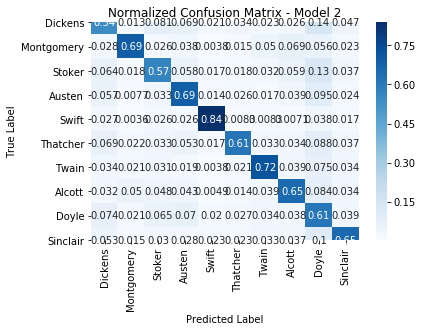

In [67]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['Dickens', 'Montgomery', 'Stoker', 'Austen', 'Swift',
                                          'Thatcher', 'Twain', 'Alcott', 'Doyle', 'Sinclair'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 2')

plt.savefig("confusion2.eps")

In [68]:
# Get benchmark statistics (random model)

# Perform 10 times and take averages

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    # Create random predictions
    author_pred3 = np.random.choice(['Dickens', 'Montgomery', 'Stoker', 'Austen', 'Swift',
                                     'Thatcher', 'Twain', 'Alcott', 'Doyle', 'Sinclair'], len(author_test))

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print("Ave. Precision:", prec_list, np.mean(prec_list), np.std(prec_list))
print("Ave. Recall:", recall_list, np.mean(recall_list), np.std(recall_list))
print("Ave. F1 Score:", f1_list, np.mean(f1_list), np.std(f1_list))

Accuracy: [0.10225, 0.104125, 0.09825, 0.0935, 0.09825, 0.099375, 0.096875, 0.09525, 0.098, 0.095] 0.09808749999999998 0.003091849163526576
Ave. Precision: [0.10238445300262267, 0.10412385905638424, 0.09850672887647932, 0.09369035467978938, 0.09823538952317161, 0.09945355099984565, 0.09696131448247802, 0.09511441000347994, 0.09818192355655164, 0.09497672824654964] 0.09816287124273522 0.0030989773900848877
Ave. Recall: [0.10224999999999998, 0.104125, 0.09824999999999999, 0.09349999999999999, 0.09824999999999999, 0.09937499999999999, 0.09687499999999999, 0.09525, 0.098, 0.09499999999999999] 0.09808749999999998 0.0030918491635265775
Ave. F1 Score: [0.10224676293129178, 0.1040281998821109, 0.0982805232783635, 0.09355403895776951, 0.09822091374099146, 0.09939029244823797, 0.09686633335467906, 0.09513981114776265, 0.09802822873606087, 0.09495818776826939] 0.09807132922455371 0.003080090718626068


In [69]:
# Model 1 Sensitivity Testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0


for train_inds, _ in kf.split(gram3_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([gram3_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    # Fit model
    model1 = define_model(350, 10, max_3gram + 1, 600, verbose = False)
    model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=3, batch_size=32, verbose = 0)
    
    # Predict values for test set
    author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1


C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Run: 2


C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Run: 3


C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Accuracy: [0.663875, 0.670375, 0.66725]
Ave. Precision: [0.6691995926465393, 0.6701962760517883, 0.6722932251136897]
Ave. Recall: [0.663875, 0.670375, 0.66725]
Ave. F1 Score: [0.6610485052092892, 0.6691583439876049, 0.6656031580043857]


In [70]:
# Model 2 sensitivity testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0

# Convert sparse matrix to array
words_train_np = words_train.toarray()

for train_inds, _ in kf.split(words_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([words_train_np[i] for i in train_inds])
    train_y = [author_train[i] for i in train_inds]
    
    # Convert train_x back to sparse matrix
    train_x = sparse.csr_matrix(train_x)
    
    # Fit model
    model2 = SVC(C = 1, kernel = 'linear')
    model2.fit(train_x, train_y)


    # Predict values for test set
    author_pred2 = model2.predict(words_test)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred2)
    precision, recall, f1, support = score(author_test, author_pred2)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Run: 2
Run: 3
Accuracy: [0.630625, 0.635625, 0.631875]
Ave. Precision: [0.6460573402558497, 0.6510100051731529, 0.6478128073203953]
Ave. Recall: [0.630625, 0.635625, 0.631875]
Ave. F1 Score: [0.635194791599523, 0.6398922182501899, 0.6364311139286697]


In [71]:
# Explore the first 100 test examples
for i in range(100):
    print('Excerpt', i, '- Actual label =', author_test[i],  'Model 1 predicted label =', author_pred1[i], 
         'Model 2 predicted label =', author_pred2[i])
    print(text_test[i], '\n')

Excerpt 0 - Actual label = Stoker Model 1 predicted label = Stoker Model 2 predicted label = Doyle
i was evidently expected for when i got near the door i faced a cheerylooking elderly woman in the usual peasant dress white undergarment with long double apron front and back of coloured stuff fitting almost too tight for modesty 

Excerpt 1 - Actual label = Sinclair Model 1 predicted label = Stoker Model 2 predicted label = Dickens
good heavens then he might have known 

Excerpt 2 - Actual label = Swift Model 1 predicted label = Swift Model 2 predicted label = Swift
in return to which i heard a great shout repeated three times giving me such transports of joy as are not to be conceived but by those who feel them 

Excerpt 3 - Actual label = Alcott Model 1 predicted label = Twain Model 2 predicted label = Alcott
but amy was a young pilgrim and just now her burden seemed very heavy 

Excerpt 4 - Actual label = Stoker Model 1 predicted label = Alcott Model 2 predicted label = Austen
oh wil

he went in and went out in an unaccountable way like a man without an object 

Excerpt 43 - Actual label = Twain Model 1 predicted label = Twain Model 2 predicted label = Twain
we got away as soon as it was good and dark 

Excerpt 44 - Actual label = Twain Model 1 predicted label = Dickens Model 2 predicted label = Twain
i took the axe and smashed in the door 

Excerpt 45 - Actual label = Dickens Model 1 predicted label = Stoker Model 2 predicted label = Dickens
but unfortunately there has been he paused and took a deep breath—a slight relapse 

Excerpt 46 - Actual label = Doyle Model 1 predicted label = Dickens Model 2 predicted label = Stoker
deserted you 

Excerpt 47 - Actual label = Stoker Model 1 predicted label = Alcott Model 2 predicted label = Alcott
i dont see where the joke comes in there either 

Excerpt 48 - Actual label = Montgomery Model 1 predicted label = Alcott Model 2 predicted label = Dickens
how are your preparations for your bazaar coming on 

Excerpt 49 - Actual l

Excerpt 90 - Actual label = Twain Model 1 predicted label = Twain Model 2 predicted label = Twain
i didnt think of that 

Excerpt 91 - Actual label = Twain Model 1 predicted label = Doyle Model 2 predicted label = Stoker
unknown friend 

Excerpt 92 - Actual label = Austen Model 1 predicted label = Austen Model 2 predicted label = Doyle
success supposes endeavour 

Excerpt 93 - Actual label = Sinclair Model 1 predicted label = Sinclair Model 2 predicted label = Sinclair
if jurgis so much as raised a hand against them back he would go into that wildbeast pen from which he had just escaped 

Excerpt 94 - Actual label = Alcott Model 1 predicted label = Alcott Model 2 predicted label = Alcott
all were busy at home john absent till night and nothing to do but sew or read or potter about 

Excerpt 95 - Actual label = Twain Model 1 predicted label = Alcott Model 2 predicted label = Doyle
oh just listen 

Excerpt 96 - Actual label = Thatcher Model 1 predicted label = Thatcher Model 2 predicted 

In [72]:
def calculate_averages(true, pred, text):
    """Calculate average length of correctly and incorrectly classified examples
    
    Args:
    true: list. List of correct labels.
    pred: list. List of predicted labels.
    text: list. List of text excerpts.
    
    Returns:
    correct_ave_chars: float. Average length of correctly classified examples in characters.
    incorrect_ave_chars: float. Average length of incorrectly classified examples in characters.
    correct_ave_words: float. Average length of correctly classified examples in characters.
    incorrect_ave_words: float. Average length of incorrectly classified examples in characters.
    """
    
    correct_len_chars = []
    incorrect_len_chars = []
    correct_len_words = []
    incorrect_len_words = []

    
    for i in range(len(true)):
        if true[i] == pred[i]:
            correct_len_chars.append(len(text[i]))
            correct_len_words.append(len(text[i].split()))
        else:
            incorrect_len_chars.append(len(text[i]))
            incorrect_len_words.append(len(text[i].split()))
    
    correct_ave_chars = np.mean(correct_len_chars)
    correct_ave_words = np.mean(correct_len_words)
    incorrect_ave_chars = np.mean(incorrect_len_chars)
    incorrect_ave_words = np.mean(incorrect_len_words)
    
    # Conduct two sample t-test
    print('Character t-test')
    print(stats.ttest_ind(correct_len_chars, incorrect_len_chars, equal_var = False))
    
    print('\nWord t-test')
    print(stats.ttest_ind(correct_len_words, incorrect_len_words, equal_var = False))
    
    return correct_ave_chars, correct_ave_words, incorrect_ave_chars, incorrect_ave_words

In [73]:
# Calculate averages for Model 1
correct_ave_chars1, correct_ave_words1, incorrect_ave_chars1, incorrect_ave_words1\
= calculate_averages(author_test, author_pred1, text_test)

Character t-test
Ttest_indResult(statistic=21.533394668975532, pvalue=1.1184367369783573e-99)

Word t-test
Ttest_indResult(statistic=21.665061810881927, pvalue=7.467085798344766e-101)


In [74]:
# Calculate averages for Model 2
correct_ave_chars2, correct_ave_words2, incorrect_ave_chars2, incorrect_ave_words2\
= calculate_averages(author_test, author_pred2, text_test)

Character t-test
Ttest_indResult(statistic=23.55686693814312, pvalue=1.2459367557946595e-118)

Word t-test
Ttest_indResult(statistic=22.957778349596353, pvalue=6.017472049712042e-113)


In [75]:
print('Model 1 - Average excerpt length (chars) of correct examples =', correct_ave_chars1, 
        'Incorrect exampes =', incorrect_ave_chars1)
print('Model 2 - Average excerpt length (chars) of correct examples =', correct_ave_chars2, 
      'Incorrect exampes =', incorrect_ave_chars2)

print('\nModel 1 - Average excerpt length (words) of correct examples =', correct_ave_words1, 
        'Incorrect exampes =', incorrect_ave_words1)
print('Model 2 - Average excerpt length (words) of correct examples =', correct_ave_words2, 
      'Incorrect exampes =', incorrect_ave_words2)

Model 1 - Average excerpt length (chars) of correct examples = 121.42787560884226 Incorrect exampes = 78.10593538692713
Model 2 - Average excerpt length (chars) of correct examples = 124.09475766567755 Incorrect exampes = 77.69134125636673

Model 1 - Average excerpt length (words) of correct examples = 23.501124016485576 Incorrect exampes = 15.350488354620586
Model 2 - Average excerpt length (words) of correct examples = 23.921463897131552 Incorrect exampes = 15.412224108658744
